# Download
https://figshare.com/projects/Tabula_Muris_Transcriptomic_characterization_of_20_organs_and_tissues_from_Mus_musculus_at_single_cell_resolution/27733

10X Single-cell RNA-seq data from microfluidic emulsion (v2)

SS2 Single-cell RNA-seq data from Smart-seq2 sequencing of FACS sorted cells (v2)

# Preprocess

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [2]:
data_path = "data_TM/full"

if not os.path.exists(data_path):
    os.makedirs(data_path)

path_SS2 = "/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/FACS"
path_10X = "/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/droplet"

meta_SS2 = pd.read_csv("/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/annotations_facs.csv", 
                       keep_default_na=False)
meta_10X = pd.read_csv("/import/home/share/Portal-reproduce/Raw_data_TabulaMuris/annotations_droplet.csv", 
                       keep_default_na=False)

# SS2
for tissue in ["Aorta", "Bladder", "Brain_Myeloid", "Brain_Non-Myeloid", "Diaphragm", "Fat", "Heart",  
               "Kidney", "Large_Intestine", "Limb_Muscle", "Liver", "Lung", "Mammary_Gland", "Marrow", 
               "Pancreas", "Skin", "Spleen", "Thymus", "Tongue", "Trachea"]:

    # Read SS2 cell-by-gene counts
    adata_SS2 = sc.read_csv(os.path.join(path_SS2, "%s-counts.csv" % tissue)).transpose()
    ERCC_idx = pd.Series(adata_SS2.var.index).str.startswith('ERCC')
    cell_idx = adata_SS2.obs.index.isin(meta_SS2[(meta_SS2.cell_ontology_class != 0) & 
                                                         (meta_SS2.cell_ontology_class != "")].cell)
    adata_SS2 = adata_SS2[cell_idx, -ERCC_idx]
    if tissue == "Aorta":
        adata_SS2_all = adata_SS2.copy()
    else:
        genes = adata_SS2_all.var.index & adata_SS2.var.index
        adata_SS2_all = adata_SS2_all[:, genes].concatenate(adata_SS2[:, genes], index_unique=None)

# 10X
for tissue in ["Bladder", "Heart_and_Aorta", "Kidney", "Limb_Muscle", "Liver", "Lung", "Mammary_Gland", 
               "Marrow", "Spleen", "Thymus", "Tongue", "Trachea"]:

    # Read 10X cell-by-gene counts
    channels = sorted(set(meta_10X[meta_10X.tissue == tissue].channel))
    for i, channel in enumerate(channels):
        if i == 0:
            adata_10X = sc.read_10x_mtx(path_10X + '/%s-%s/' % (tissue, channel), 
                                        var_names='gene_symbols',cache=False)
            adata_10X.obs.index = channel + "_" + adata_10X.obs.index
            adata_10X.obs.index = adata_10X.obs.index.map(lambda x: x[:-2])
            cell_idx = adata_10X.obs.index.isin(meta_10X[(meta_10X.cell_ontology_class != 0) &
                                                         (meta_10X.cell_ontology_class != "")].cell)
            adata_10X = adata_10X[cell_idx, :]
        else:
            tmp = sc.read_10x_mtx(path_10X + '/%s-%s/' % (tissue, channel), 
                                  var_names='gene_symbols',cache=False)
            tmp.obs.index = channel + "_" + tmp.obs.index
            tmp.obs.index = tmp.obs.index.map(lambda x: x[:-2])
            cell_idx = tmp.obs.index.isin(meta_10X[(meta_10X.cell_ontology_class != 0) &
                                                   (meta_10X.cell_ontology_class != "")].cell)
            adata_10X = adata_10X.concatenate(tmp[cell_idx, :], index_unique=None)
    if tissue == "Bladder":
        adata_10X_all = adata_10X.copy()
    else:
        genes = adata_10X_all.var.index & adata_10X.var.index
        adata_10X_all = adata_10X_all[:, genes].concatenate(adata_10X[:, genes], index_unique=None)

celltype_SS2 = meta_SS2[meta_SS2.cell.isin(adata_SS2_all.obs.index)][["cell", "tissue", "cell_ontology_class"]].set_index("cell")
celltype_SS2["method"] = "SS2"
celltype_10X = meta_10X[meta_10X.cell.isin(adata_10X_all.obs.index)][["cell", "tissue", "cell_ontology_class"]].set_index("cell")
celltype_10X["method"] = "10X"
meta = pd.concat([celltype_SS2, celltype_10X]).rename(columns={"cell_ontology_class": "celltype"})
meta.to_pickle(os.path.join(data_path, "meta_raw.pkl"))

sc.pp.filter_cells(adata_SS2_all, min_genes=200)
sc.pp.filter_genes(adata_SS2_all, min_cells=3)
sc.pp.filter_cells(adata_10X_all, min_genes=200)
sc.pp.filter_genes(adata_10X_all, min_cells=3)

meta = meta.loc[list(adata_SS2_all.obs.index) + list(adata_10X_all.obs.index), ]
meta.to_pickle(os.path.join(data_path, "meta.pkl"))

adata_SS2_all.write(filename=os.path.join(data_path, "adata_SS2.h5ad"))
adata_10X_all.write(filename=os.path.join(data_path, "adata_10X.h5ad"))

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading fr

# Integration using Portal

In [3]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Create a folder for saving results
result_path = "./result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [4]:
model = portal.model.Model(training_steps=1000, lambdacos=95.0)
model.preprocess(adata_SS2_all, adata_10X_all) # perform preprocess and PCA
model.train() # train the model
model.eval(D_score=True) # get integrated latent representation of cells

# portal.utils.plot_UMAP(model.latent, meta, colors=["method", "celltype"], save=True, result_path=result_path)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell


Normalizing and scaling...


    finished (0:00:00)
/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Dimensionality reduction via PCA...
Begining time:  Mon Apr 18 22:40:53 2022
step 0, loss_D=16.465668, loss_GAN=3.280006, loss_AE=574.403320, loss_cos=196.055283, loss_LA=445.092316
step 200, loss_D=1.705626, loss_GAN=4.708693, loss_AE=8.140835, loss_cos=6.614666, loss_LA=3.321220
step 400, loss_D=1.520525, loss_GAN=4.517472, loss_AE=5.064828, loss_cos=4.586500, loss_LA=1.815456
step 600, loss_D=1.915906, loss_GAN=4.614635, loss_AE=4.114102, loss_cos=4.220361, loss_LA=1.216388
step 800, loss_D=1.715044, loss_GAN=4.681593, loss_AE=3.157011, loss_cos=3.949149, loss_LA=0.988348
Ending time:  Mon Apr 18 22:41:18 2022
Training takes 25.33 seconds
Begining time:  Mon Apr 18 22:41:18 2022
Ending time:  Mon Apr 18 22:41:18 2022
Evaluating takes 0.05 seconds


In [5]:
# reproduce figure in paper

from sklearn import preprocessing
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import umap

meta = pd.read_pickle(os.path.join("data_TM/full", "meta.pkl"))

le = preprocessing.LabelEncoder()
le.fit(sorted(set(meta["method"])))
label = le.fit_transform(meta["method"].values)
colours = ListedColormap(["tab:blue", "tab:orange"])

rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new

le2 = preprocessing.LabelEncoder()
le2.fit(sorted(set(meta["tissue"])))
label2 = le.fit_transform(meta["tissue"].values)
if len(sorted(set(meta["tissue"]))) <= 12:
    colours2 = ListedColormap(rgb2hex_10)
elif len(sorted(set(meta["tissue"]))) <= 20:
    colours2 = ListedColormap(rgb2hex_20)
elif len(sorted(set(meta["tissue"]))) <= 40:
    colours2 = ListedColormap(rgb2hex)
else:
    colours2 = "rainbow"

    
le3 = preprocessing.LabelEncoder()
le3.fit(sorted(set(meta["celltype"].values)))
label3 = le3.transform(meta["celltype"].values)
colours3 = "rainbow"

reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)

embedding = reducer.fit_transform(model.latent)

n_cells = embedding.shape[0]
size = 120000 / n_cells

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Mon Apr 18 22:41:18 2022 Finding Nearest Neighbors
Mon Apr 18 22:41:18 2022 Building RP forest with 21 trees
Mon Apr 18 22:41:22 2022 NN descent for 17 iterations
	 0  /  17
	 1  /  17
	 2  /  17
	 3  /  17
Mon Apr 18 22:42:02 2022 Finished Nearest Neighbor Search


/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Mon Apr 18 22:42:07 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Apr 18 22:45:40 2022 Finished embedding


UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Mon Apr 18 22:45:41 2022 Finding Nearest Neighbors
Mon Apr 18 22:45:41 2022 Building RP forest with 21 trees
Mon Apr 18 22:45:44 2022 NN descent for 17 iterations
	 0  /  17
	 1  /  17
	 2  /  17
	 3  /  17
Mon Apr 18 22:46:19 2022 Finished Nearest Neighbor Search
Mon Apr 18 22:46:23 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Apr 18 22:50:02 2022 Finished embedding


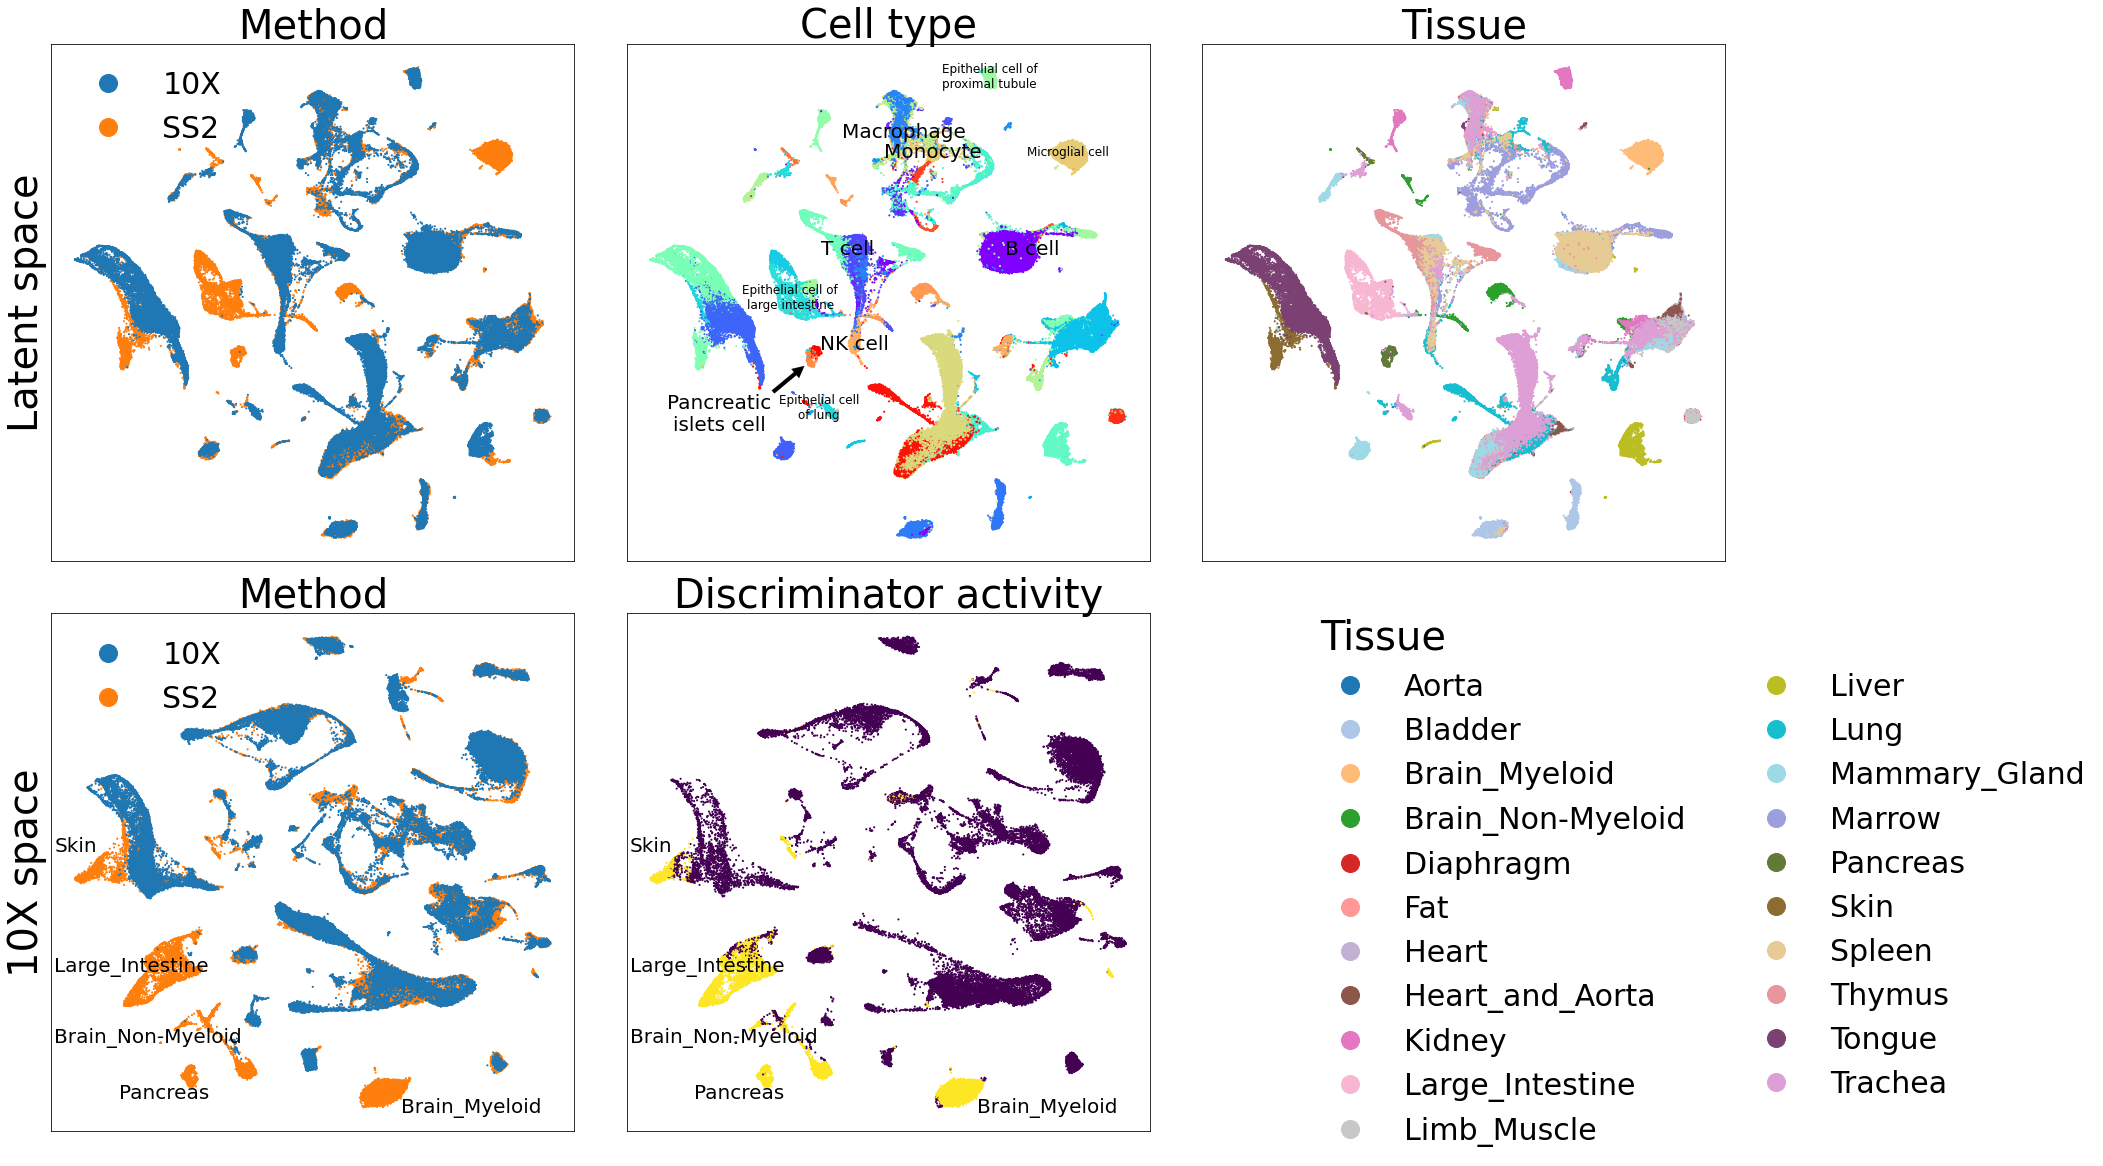

In [6]:
f = plt.figure(figsize=(30,20))

# Ours
ax2 = f.add_subplot(2,3,1)
scatter1 = ax2.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label, cmap=colours, label=meta["method"].values)
ax2.set_title("Method", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2.set_ylabel("Latent space", fontsize=40)
ax2.legend(handles=scatter1.legend_elements(num=len(sorted(set(meta["method"]))))[0], labels=sorted(set(meta["method"])), loc="upper left", bbox_to_anchor=(0.0, 1.0), 
           markerscale=3., title_fontsize=40, fontsize=30, frameon=False, ncol=1, title=None)
# tissue
ax22 = f.add_subplot(2,3,3)
scatter2 = ax22.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label2, cmap=colours2)#, label=meta["tissue"].values)
ax22.set_title("Tissue", fontsize=40)
ax22.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
# celltype
ax23 = f.add_subplot(2,3,2)
ax23.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label3, cmap=colours3, label=meta["celltype"].values)
ax23.set_title("Cell type", fontsize=40)
ax23.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax23.annotate("B cell", rotation=0, fontsize=20, xy=(16, 5.5), ha='center', va='center')
ax23.annotate("Macrophage", rotation=0, fontsize=20, xy=(7, 14), ha='center', va='center')
ax23.annotate("Monocyte", rotation=0, fontsize=20, xy=(9, 12.5), ha='center', va='center')
ax23.annotate("NK cell", rotation=0, fontsize=20, xy=(3.5, -1.4), ha='center', va='center')
ax23.annotate("T cell", rotation=0, fontsize=20, xy=(3, 5.5), ha='center', va='center')
ax23.annotate("Epithelial cell of\nlarge intestine", rotation=0, fontsize=12, xy=(-1, 2), ha='center', va='center')
ax23.annotate("Epithelial cell\nof lung", rotation=0, fontsize=12, xy=(1, -6), ha='center', va='center')
ax23.annotate("Epithelial cell of\nproximal tubule", rotation=0, fontsize=12, xy=(13, 18), ha='center', va='center')
ax23.annotate("Microglial cell", rotation=0, fontsize=12, xy=(18.5, 12.5), ha='center', va='center')
ax23.annotate("Pancreatic\nislets cell", rotation=0, fontsize=20, xytext=(-6, -6.5), xy=(0., -3.), ha='center', va='center', arrowprops=dict(color='black', lw=.1, ls='-', ))

# Bspace
ax3 = f.add_subplot(2,3,4)
embedding = reducer.fit_transform(model.data_Bspace)
ax3.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label, cmap=colours, label=meta["method"].values)
ax3.set_title("Method", fontsize=40)
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax3.set_ylabel("10X space", fontsize=40)
ax3.annotate("Brain_Myeloid", rotation=0, fontsize=20, xy=(12.5 , -16))
ax3.annotate("Skin", rotation=0, fontsize=20, xy=(-9, 2.5))
ax3.annotate("Large_Intestine", rotation=0, fontsize=20, xy=(-9, -6))
ax3.annotate("Pancreas", rotation=0, fontsize=20, xy=(-5, -15))
ax3.annotate("Brain_Non-Myeloid", rotation=0, fontsize=20, xy=(-9, -11))
ax3.legend(handles=scatter1.legend_elements(num=len(sorted(set(meta["method"]))))[0], labels=sorted(set(meta["method"])), loc="upper left", bbox_to_anchor=(0.0, 1.0), 
           markerscale=3., title_fontsize=40, fontsize=30, frameon=False, ncol=1, title=None)

ax32 = f.add_subplot(2,3,5)
score = model.score_Bspace[:model.emb_A.shape[0]]
score = (score < -5.0).astype(int)
ax32.scatter(embedding[meta["method"]=="SS2", 0], embedding[meta["method"]=="SS2", 1], s=size, c=score)
ax32.set_title("Discriminator activity", fontsize=40)
ax32.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax32.annotate("Brain_Myeloid", rotation=0, fontsize=20, xy=(12.5 , -16))
ax32.annotate("Skin", rotation=0, fontsize=20, xy=(-9, 2.5))
ax32.annotate("Large_Intestine", rotation=0, fontsize=20, xy=(-9, -6))
ax32.annotate("Pancreas", rotation=0, fontsize=20, xy=(-5, -15))
ax32.annotate("Brain_Non-Myeloid", rotation=0, fontsize=20, xy=(-9, -11))

l2 = f.legend(handles=scatter2.legend_elements(num=len(sorted(set(meta["tissue"]))))[0], labels=sorted(set(meta["tissue"])), loc="upper left", bbox_to_anchor=(0.7, 0.5), 
              markerscale=3., title_fontsize=40, fontsize=30, frameon=False, ncol=2, title="Tissue")

l2._legend_box.align = "left"
f.subplots_adjust(hspace=.1, wspace=.1)

# Analysis

In [7]:
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

meta = pd.read_pickle(os.path.join(data_path, "meta.pkl"))

adata_SS2 = anndata.read_h5ad(os.path.join(data_path, "adata_SS2.h5ad"))
meta_SS2 = meta.loc[adata_SS2.obs.index]
adata_SS2 = anndata.AnnData(X=adata_SS2.X, obs=meta_SS2, var=adata_SS2.var).copy()
adata_10X = anndata.read_h5ad(os.path.join(data_path, "adata_10X.h5ad"))
meta_10X = meta.loc[adata_10X.obs.index]
adata_10X = anndata.AnnData(X=adata_10X.X, obs=meta_10X, var=adata_10X.var).copy()

In [8]:
sc.pp.normalize_total(adata_SS2, target_sum=1e4)
sc.pp.log1p(adata_SS2)

normalizing counts per cell
    finished (0:00:00)


In [9]:
sc.pp.highly_variable_genes(adata_SS2, flavor='seurat_v3', n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [10]:
hvg = adata_SS2.var[adata_SS2.var.highly_variable == True].sort_values(by="highly_variable_rank").index

In [11]:
adata_1 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "B cell"), list(hvg)].copy()
adata_2 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "naive B cell"), list(hvg)].copy()
adata_3 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "immature B cell"), list(hvg)].copy()
adata_4 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "precursor B cell"), list(hvg)].copy()
adata_5 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "late pro-B cell"), list(hvg)].copy()

adata_new = adata_1.concatenate(adata_2, index_unique=None)
adata_new = adata_new.concatenate(adata_3, index_unique=None)
adata_new = adata_new.concatenate(adata_4, index_unique=None)
adata_new = adata_new.concatenate(adata_5, index_unique=None)

In [12]:
cov = np.corrcoef(adata_new.X)

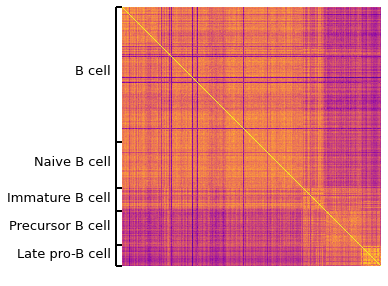

In [13]:
f = plt.figure(figsize=(5,5))
im = plt.imshow(cov, cmap='plasma', interpolation='nearest')
plt.axis("off")
# plt.colorbar(shrink=0.7)

plt.vlines(-100, 0, adata_new.shape[0], lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(0, -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_1.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_1.shape[0]+adata_2.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_1.shape[0]+adata_2.shape[0]+adata_3.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_1.shape[0]+adata_2.shape[0]+adata_3.shape[0]+adata_4.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_new.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)

x1 = adata_1.shape[0]/2
x2 = adata_1.shape[0] + adata_2.shape[0]/2
x3 = adata_1.shape[0] + adata_2.shape[0] + adata_3.shape[0]/2
x4 = adata_1.shape[0] + adata_2.shape[0] + adata_3.shape[0] + adata_4.shape[0]/2
x5 = adata_1.shape[0] + adata_2.shape[0] + adata_3.shape[0] + adata_4.shape[0] + adata_5.shape[0]/2

plt.annotate('B cell', fontsize=13, ha='right', xy=(-170, x1))
plt.annotate('Naive B cell', fontsize=13, ha='right', xy=(-170, x2+10))
plt.annotate('Immature B cell', fontsize=13, ha='right', xy=(-170, x3+35))
plt.annotate('Precursor B cell', fontsize=13, ha='right', xy=(-170, x4+25))
plt.annotate('Late pro-B cell', fontsize=13, ha='right', xy=(-170, x5+35))

plt.savefig("TM-corr-B-a.pdf", dpi=350, bbox_inches='tight')

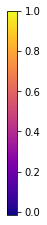

In [14]:
fig,ax = plt.subplots(figsize=(5,5))
plt.colorbar(im, ax=ax, shrink=0.75)
ax.remove()
plt.savefig("TM-corr-B-b.pdf", dpi=350, bbox_inches='tight')

In [15]:
adata_1 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "epithelial cell of large intestine"), list(hvg)].copy()
adata_2 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "epithelial cell of lung"), list(hvg)].copy()
adata_3 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "epithelial cell of proximal tubule"), list(hvg)].copy()

adata_new = adata_1.concatenate(adata_2, index_unique=None)
adata_new = adata_new.concatenate(adata_3, index_unique=None)

In [16]:
cov = np.corrcoef(adata_new.X)

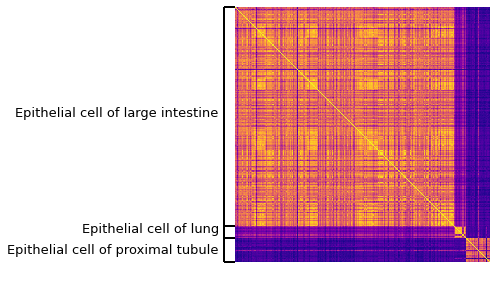

In [17]:
f = plt.figure(figsize=(5,5))
im = plt.imshow(cov, cmap='plasma', interpolation='nearest')
plt.axis("off")

plt.vlines(-100, 0, adata_new.shape[0], lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(0, -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_1.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_1.shape[0]+adata_2.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_new.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)

x1 = adata_1.shape[0]/2
x2 = adata_1.shape[0] + adata_2.shape[0]/2
x3 = adata_1.shape[0] + adata_2.shape[0] + adata_3.shape[0]/2

plt.annotate('Epithelial cell of large intestine', fontsize=13, ha='right', xy=(-150, x1))
plt.annotate('Epithelial cell of lung', fontsize=13, ha='right', xy=(-150, x2+10))
plt.annotate('Epithelial cell of proximal tubule', fontsize=13, ha='right', xy=(-150, x3+35))

plt.savefig("TM-corr-epi-a.pdf", dpi=350, bbox_inches='tight')

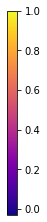

In [18]:
fig,ax = plt.subplots(figsize=(5,5))
plt.colorbar(im, ax=ax, shrink=0.75)
ax.remove()
plt.savefig("TM-corr-epi-b.pdf", dpi=350, bbox_inches='tight')

In [19]:
adata_1 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "microglial cell"), list(hvg)].copy()
adata_2 = adata_SS2[(adata_SS2.obs.celltype.astype(str) == "macrophage") & (adata_SS2.obs.tissue.astype(str) == "Marrow"), list(hvg)].copy()

adata_new = adata_1.concatenate(adata_2, index_unique=None)

In [20]:
cov = np.corrcoef(adata_new.X)

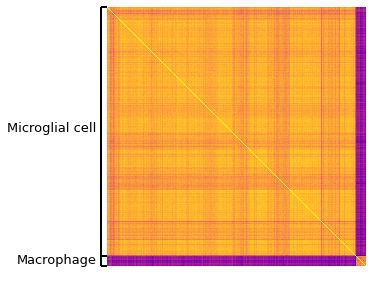

In [21]:
f = plt.figure(figsize=(5,5))
plt.imshow(cov, cmap='plasma', interpolation='nearest')
plt.axis("off")

plt.vlines(-100, 0, adata_new.shape[0], lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(0, -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_1.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)
plt.hlines(adata_new.shape[0], -100, 0, lw=2, color='black', zorder=10, clip_on=False)

x1 = adata_1.shape[0]/2
x2 = adata_1.shape[0] + adata_2.shape[0]/2

plt.annotate('Microglial cell', fontsize=13, ha='right', xy=(-180, x1))
plt.annotate('Macrophage', fontsize=13, ha='right', xy=(-180, x2+50))

plt.savefig("TM-corr-m-a.pdf", dpi=350, bbox_inches='tight')

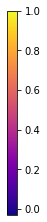

In [22]:
fig,ax = plt.subplots(figsize=(5,5))
plt.colorbar(im, ax=ax, shrink=0.75)
ax.remove()
plt.savefig("TM-corr-m-b.pdf", dpi=350, bbox_inches='tight')